## Загрузка

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"polinacher","key":"a241d6c303b034abeb741c7c5796777c"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d polinacher/diamonds-clear

  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 79.0MB/s]


In [ ]:
! unzip  '/content/diamonds-clear.zip' -d '/content/diamonds-clear'

Archive:  /content/diamonds-clear.zip
  inflating: /content/diamonds-clear/diamonds_clear.csv  


## Подготовка

In [ ]:
import pandas as pd
import matplotlib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split # разделение датасета на тренировочный и тестовый
import imblearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.ensemble import RandomForestClassifier

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/diamonds-clear/diamonds_clear.csv')
df

,carat,cut,color,clarity,depth percentage,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
3,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
4,0.24,Very Good,J,VVS2,62.8,57.0,336.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...,...
42930,0.72,Ideal,D,SI1,60.8,57.0,2757.0,5.75,5.76,3.50
42931,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
42932,0.70,Very Good,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
42933,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


In [ ]:
df = df.drop('table', axis = 1) # удаление столбцов, имеющих нейтральную коррелляцию с ценой
df = df.drop('depth percentage', axis = 1)
df = df.drop('color', axis = 1)
df = df.drop('cut', axis = 1)
df = df.drop('clarity', axis = 1)


df

,carat,price,length,width,depth
0,0.23,326.0,3.95,3.98,2.43
1,0.21,326.0,3.89,3.84,2.31
2,0.29,334.0,4.20,4.23,2.63
3,0.31,335.0,4.34,4.35,2.75
4,0.24,336.0,3.94,3.96,2.48
...,...,...,...,...,...
42930,0.72,2757.0,5.75,5.76,3.50
42931,0.72,2757.0,5.69,5.75,3.61
42932,0.70,2757.0,5.66,5.68,3.56
42933,0.86,2757.0,6.15,6.12,3.74


In [ ]:
df['price'].max() # максимальная цена

11856.0

In [ ]:
def divide_price(row): # разделение цены на категории
    if row['price'] <= 500:
      row['price_limit'] = 500
    elif row['price'] <= 1000:
      row['price_limit'] = 1000
    elif row['price'] <= 2000:
      row['price_limit'] = 2000
    elif row['price'] <= 3000:
      row['price_limit'] = 3000
    elif row['price'] <= 4000:
      row['price_limit'] = 4000
    elif row['price'] <= 5000:
      row['price_limit'] = 5000
    elif row['price'] <= 6000:
      row['price_limit'] = 6000
    elif row['price'] <= 7000:
      row['price_limit'] = 7000
    elif row['price'] <= 8000:
      row['price_limit'] = 8000
    elif row['price'] <= 9000:
      row['price_limit'] = 9000
    elif row['price'] <= 10000:
      row['price_limit'] = 10000
    elif row['price'] <= 11000:
      row['price_limit'] = 11000
    elif row['price'] <= 15000:
      row['price_limit'] = 15000
    return row

df = df.apply(divide_price, axis=1) # применение функции к каждой строке

df

,carat,price,length,width,depth,price_limit
0,0.23,326.0,3.95,3.98,2.43,500.0
1,0.21,326.0,3.89,3.84,2.31,500.0
2,0.29,334.0,4.20,4.23,2.63,500.0
3,0.31,335.0,4.34,4.35,2.75,500.0
4,0.24,336.0,3.94,3.96,2.48,500.0
...,...,...,...,...,...,...
42930,0.72,2757.0,5.75,5.76,3.50,3000.0
42931,0.72,2757.0,5.69,5.75,3.61,3000.0
42932,0.70,2757.0,5.66,5.68,3.56,3000.0
42933,0.86,2757.0,6.15,6.12,3.74,3000.0


In [ ]:
df['price_limit'].value_counts()

1000.0     11314
2000.0      8321
3000.0      5079
5000.0      3869
4000.0      3453
6000.0      2712
7000.0      1940
500.0       1525
8000.0      1425
9000.0      1084
10000.0      902
11000.0      771
15000.0      540
Name: price_limit, dtype: int64

<Axes: xlabel='price_limit', ylabel='count'>

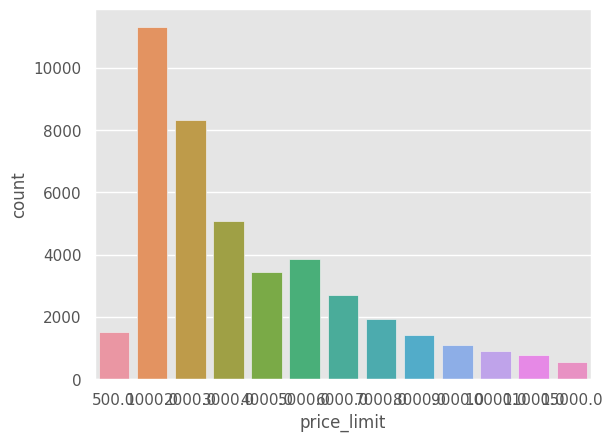

In [ ]:
 # определение несбалансированности классов
sns.countplot(x ='price_limit', data = df)

In [ ]:
y = df['price_limit'] # целевая переменная
df = df.drop('price', axis = 1)
df = df.drop('price_limit', axis = 1)
df

,carat,length,width,depth
0,0.23,3.95,3.98,2.43
1,0.21,3.89,3.84,2.31
2,0.29,4.20,4.23,2.63
3,0.31,4.34,4.35,2.75
4,0.24,3.94,3.96,2.48
...,...,...,...,...
42930,0.72,5.75,5.76,3.50
42931,0.72,5.69,5.75,3.61
42932,0.70,5.66,5.68,3.56
42933,0.86,6.15,6.12,3.74


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Создание объекта MinMaxScaler
scaler = MinMaxScaler()

# Нормализация всех столбцов в DataFrame df
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X = pd.DataFrame(df, index = df.index, columns = df.columns) # данные для предсказания
X

,carat,length,width,depth
0,0.016667,0.048352,0.059211,0.262211
1,0.005556,0.035165,0.028509,0.231362
2,0.050000,0.103297,0.114035,0.313625
3,0.061111,0.134066,0.140351,0.344473
4,0.022222,0.046154,0.054825,0.275064
...,...,...,...,...
42930,0.288889,0.443956,0.449561,0.537275
42931,0.288889,0.430769,0.447368,0.565553
42932,0.277778,0.424176,0.432018,0.552699
42933,0.366667,0.531868,0.528509,0.598972


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)# stratify = y

<Axes: xlabel='price_limit', ylabel='count'>

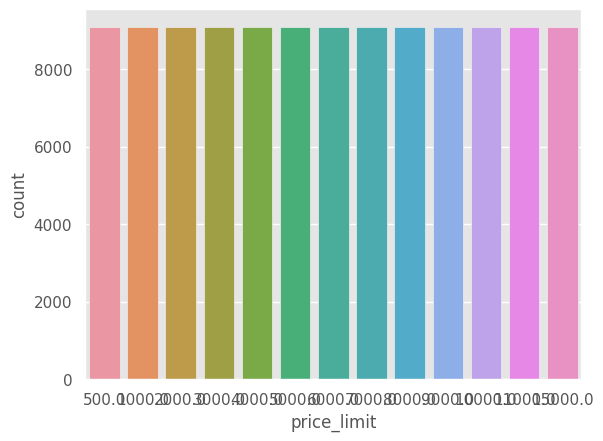

In [ ]:

from imblearn.over_sampling import SMOTE
oversample = SMOTE() # устранение дисбаланса классов
X_train, y_train = oversample.fit_resample(X_train, y_train)
sns.countplot(x = y_train, data = df)

In [ ]:
y_train.value_counts()

1000.0     9086
3000.0     9086
500.0      9086
6000.0     9086
15000.0    9086
2000.0     9086
5000.0     9086
4000.0     9086
7000.0     9086
9000.0     9086
8000.0     9086
10000.0    9086
11000.0    9086
Name: price_limit, dtype: int64

In [ ]:
from sklearn.utils import resample

# Пример сэмплирования
X, y = resample(X_train, y_train, n_samples=4000, random_state=42)

##Определение количества кластеров

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import seaborn as sns
from sklearn.metrics import silhouette_score

sns.set(style="white")
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

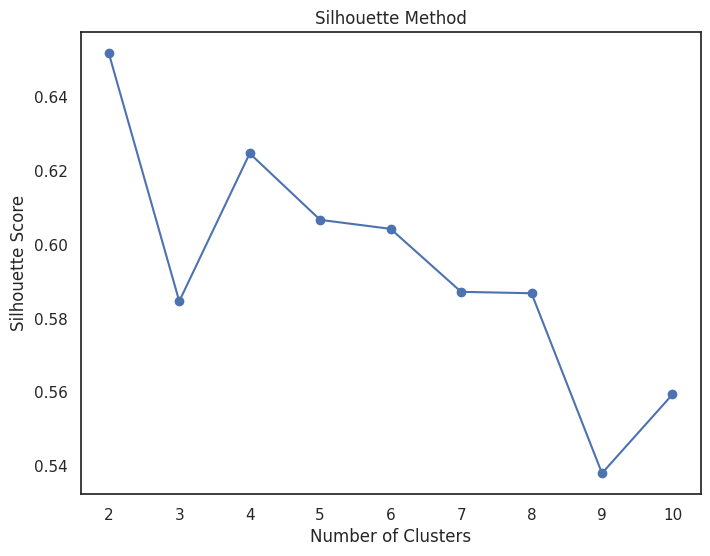

In [ ]:
#определение количества кластеров перебором

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)

    labels = kmeans.fit_predict(X)

    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

##K-means + оценка

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# PCA (метод главных компонент)
res = PCA().fit_transform(X)

print(f"\nSilhouette score: {metrics.silhouette_score(X, kmeans.labels_)}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Silhouette score: 0.6519526385054095



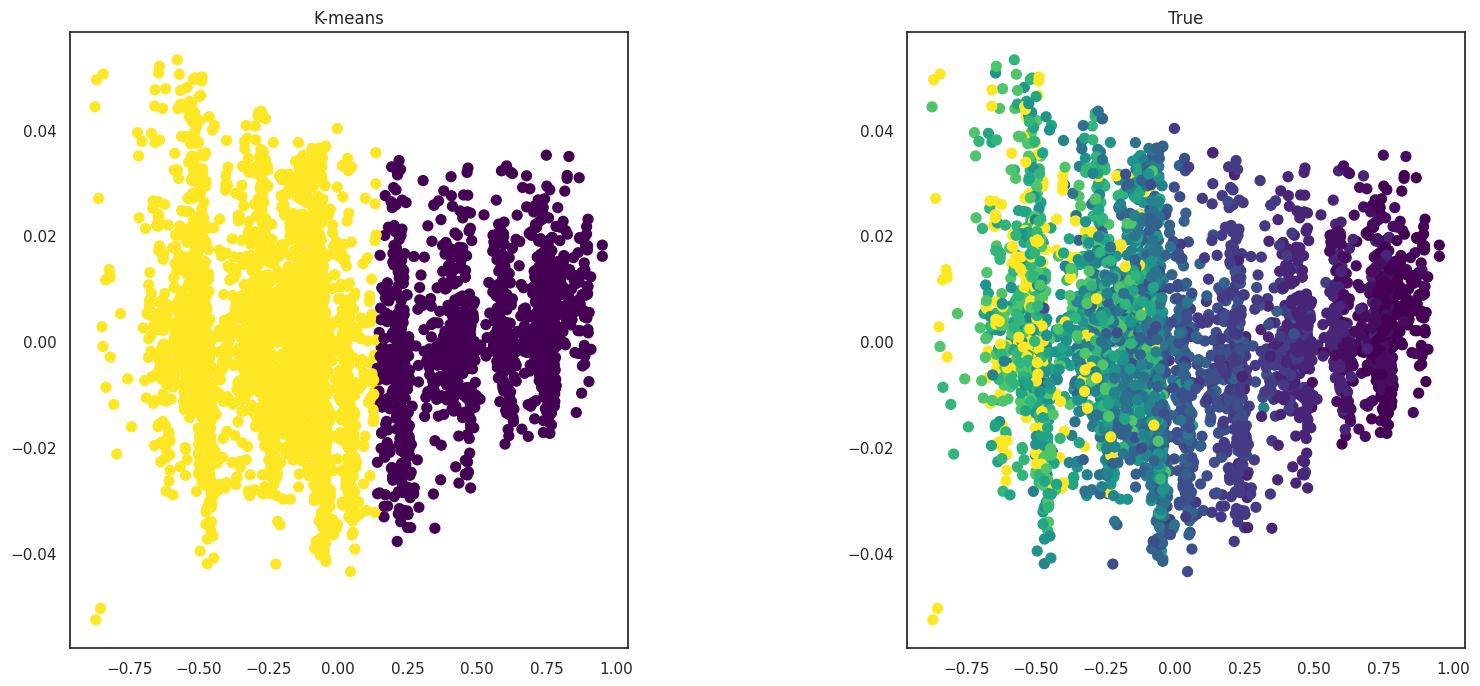

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

axes[0].scatter(res[:, 0], res[:, 2], c=kmeans.labels_, s=50, cmap='viridis')
axes[0].set_title('K-means')

axes[1].scatter(res[:, 0], res[:, 2], c=y.to_numpy(), s=50, cmap='viridis')
axes[1].set_title('True')

plt.subplots_adjust(wspace=0.5)

plt.show()

## DBSCAN + Gridsearch

In [ ]:

pipeline_dbscan = Pipeline([
    ('pca', PCA()),
    ('dbscan', DBSCAN())
])

param_grid_dbscan = {
    'dbscan__eps': [0.035, 0.045, 0.08, 0.005],
    'dbscan__min_samples': [32, 64, 256, 512],
}

silhouette_scorer_dbscan = make_scorer(silhouette_score)

grid_search_dbscan = GridSearchCV(pipeline_dbscan,
                                  param_grid=param_grid_dbscan,
                                  scoring=silhouette_scorer_dbscan,
                                  n_jobs=-1)

grid_search_dbscan.fit(X)

print("Best Parameters for DBSCAN: ", grid_search_dbscan.best_params_)

best_dbscan = grid_search_dbscan.best_estimator_

# PCA (метод главных компонент)
pca = PCA(n_components=3)
res = pca.fit_transform(X)


labels_dbscan = best_dbscan.named_steps['dbscan'].fit_predict(X)

print(f"\nBest Silhouette score for DBSCAN: {metrics.silhouette_score(X, labels_dbscan)}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for DBSCAN:  {'dbscan__eps': 0.035, 'dbscan__min_samples': 32}

Best Silhouette score for DBSCAN: 0.38930593263904917



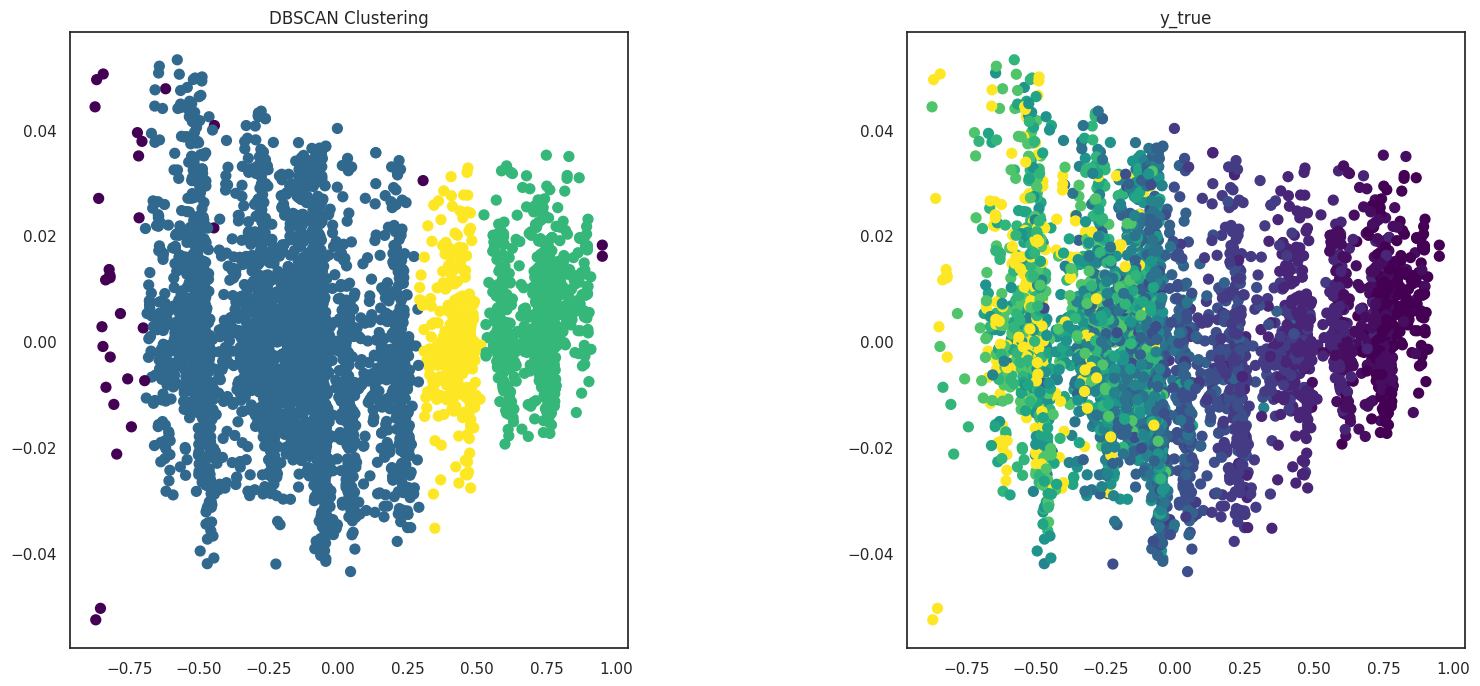

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# График для DBSCAN
axes[0].scatter(res[:, 0], res[:, 2], c=labels_dbscan, cmap='viridis', s=50)
axes[0].set_title('DBSCAN Clustering')

# График для y_true
axes[1].scatter(res[:, 0], res[:, 2], c=y.to_numpy(), s=50, cmap='viridis')
axes[1].set_title('y_true')

plt.subplots_adjust(wspace=0.5)
plt.show()

##Иерархическая кластеризация

In [ ]:

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

pipeline_agglomerative = Pipeline([
    ('pca', PCA()),
    ('agglomerative', AgglomerativeClustering())
])

param_grid_agglomerative = {
    'agglomerative__n_clusters': [2, 3, 4, 5], # сколько кластеров дб сформировано
    'agglomerative__linkage': ['ward', 'complete', 'average', 'single'] # сп. объединения: мин-я дисперсии внутри кл., макс. расст. м/у точками, ср. расст. м/у всеми парами точек в двух кластерах, мин. расст. м/у всеми парами точек в двух кластерах
}

silhouette_scorer_agglomerative = make_scorer(silhouette_score)

grid_search_agglomerative = GridSearchCV(
    pipeline_agglomerative,
    param_grid=param_grid_agglomerative,
    cv=5,
    scoring=silhouette_scorer_agglomerative,
    n_jobs=-1
)
grid_search_agglomerative.fit(X)

print("Best Parameters for Agglomerative Clustering: ",
      grid_search_agglomerative.best_params_)

best_agglomerative = grid_search_agglomerative.best_estimator_

X_pca_agglomerative = best_agglomerative.named_steps['pca'].fit_transform(X)

labels_agglomerative = best_agglomerative.named_steps['agglomerative'].labels_

print("\nBest Silhouette score for Agglomerative Clustering: \n",
      metrics.silhouette_score(X, labels_agglomerative))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for Agglomerative Clustering:  {'agglomerative__linkage': 'ward', 'agglomerative__n_clusters': 2}

Best Silhouette score for Agglomerative Clustering: 
 0.6459010847303734


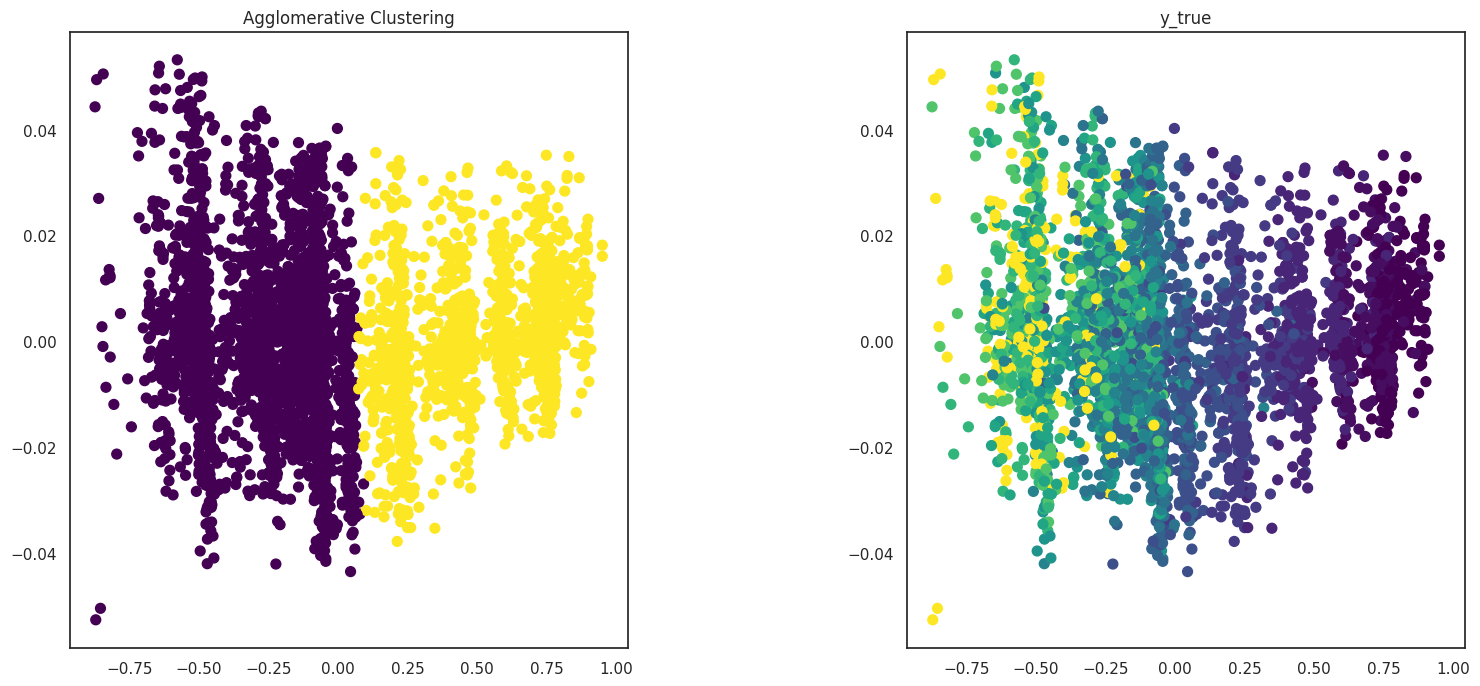

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

axes[0].scatter(X_pca_agglomerative[:, 0], X_pca_agglomerative[:, 2], c=labels_agglomerative, cmap='viridis', s=50)
axes[0].set_title('Agglomerative Clustering')

axes[1].scatter(res[:, 0], res[:, 2], c=y.to_numpy(), s=50, cmap='viridis')
axes[1].set_title('y_true')

plt.subplots_adjust(wspace=0.5)

plt.show()